In [1]:
pip install wfdb

     |████████████████████████████████| 137 kB 8.1 MB/s 
     |████████████████████████████████| 11.2 MB 68.7 MB/s 
     |████████████████████████████████| 895 kB 60.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=58611733eeed58fb7a802f9572cae0a208b65950098363eadd32a9eaf7c6c8f7
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import wfdb
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import posixpath
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
import wget
import zipfile

In [6]:
#loading dataset from physionet
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2022-02-01 17:42:08 (763 MB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2022-02-01 17:42:08--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M  --.-KB/s    in 0.04s   

2022-02-01 17:42:09 (43.2 MB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2022-02-01 17:42:09--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet.

In [7]:
#by loading dataset from drive
database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

In [8]:
records = np.loadtxt("/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

In [9]:
import numpy as np
record2 = wfdb.rdrecord('a103l', pn_dir='challenge-2015/training/')
display(records)

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234])

In [10]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"]

In [11]:
#for classification of Arrhythmia classes 
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0    

In [12]:
#function of determine the starts and ends of signals beacause of noise 
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [13]:
#adding annotation of the signals of ECG signals visualization 
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'/content/physionet.org/files/mitdb/1.0.0/{subject}')
    annotation = wfdb.rdann(f'/content/physionet.org/files/mitdb/1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    #return all the files that classify of signals 
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [14]:
subject_map = pd.DataFrame(subject_map)

In [15]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

In [16]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

In [17]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [18]:
#divide the files into training and testing data
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [19]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

In [20]:
#Deep Learning Model and neural network of the model that using activation function relu the best 
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,BatchNormalization,Flatten,MaxPool1D,Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model=Sequential()
model.add(Conv1D(32,(3),strides=(1),padding='same',activation='relu',input_shape=(2160,1) ))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Conv1D(64,(3),strides=(1),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Conv1D(64,(3),strides=(1),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(lr=0.001)
# Compiling the model
model.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2160, 32)          128       
                                                                 
 batch_normalization (BatchN  (None, 2160, 32)         128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1080, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1080, 64)          6208      
                                                                 
 batch_normalization_1 (Batc  (None, 1080, 64)         256       
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
#for begin data training and validation with epochs
hist_cnn = model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20
648/648 [==============================] - 25s 38ms/step - loss: 0.1581 - accuracy: 0.9523 - val_loss: 0.4896 - val_accuracy: 0.8516
Epoch 2/20
648/648 [==============================] - 24s 38ms/step - loss: 0.0514 - accuracy: 0.9835 - val_loss: 0.5107 - val_accuracy: 0.8717
Epoch 3/20
648/648 [==============================] - 25s 39ms/step - loss: 0.0343 - accuracy: 0.9887 - val_loss: 0.5784 - val_accuracy: 0.8719
Epoch 4/20
648/648 [==============================] - 24s 38ms/step - loss: 0.0237 - accuracy: 0.9920 - val_loss: 0.6892 - val_accuracy: 0.8701
Epoch 5/20
648/648 [==============================] - 25s 38ms/step - loss: 0.0200 - accuracy: 0.9935 - val_loss: 0.9070 - val_accuracy: 0.7969
Epoch 6/20
648/648 [==============================] - 24s 38ms/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.6136 - val_accuracy: 0.8512
Epoch 7/20
648/648 [==============================] - 24s 38ms/step - loss: 0.0126 - accuracy: 0.9959 - val_loss: 0.8521 - val_accuracy:

In [23]:
model.evaluate(X_val, y_val)

821/821 [==============================] - 4s 5ms/step - loss: 1.7868 - accuracy: 0.8391


[1.786806583404541, 0.8391408920288086]

In [24]:
pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 9.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


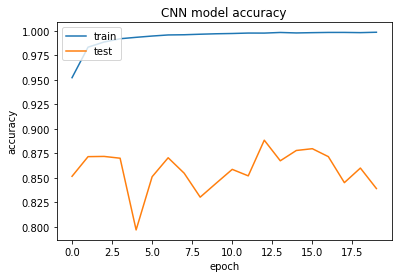

In [25]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

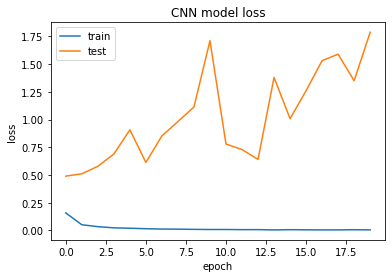

In [26]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
sequence_size = X_train.shape[1]
n_features = 1 
n_subsequences = 4
subsequence_size = int(sequence_size / n_subsequences)

# Reshaping to be (samples, subsequences, sequence, feature)
X_train = X_train.reshape(-1, n_subsequences, subsequence_size, n_features)
X_val = X_val.reshape(-1, n_subsequences, subsequence_size, n_features)

In [28]:
cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=8,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    TimeDistributed(Flatten()),
    LSTM(units=4),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 4, 540, 8)        40        
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 4320)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 4)                 69200     
                                                                 
 output (Dense)              (None, 1)                 5         
                                                                 
Total params: 69,245
Trainable params: 69,245
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
train_params = {
    "batch_size": 128,
    "epochs": 30,
    "verbose": 1,
    "validation_data": (X_val, y_val),
}

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, **train_params)

Epoch 1/30
648/648 [==============================] - 11s 9ms/step - loss: 0.4228 - accuracy: 0.7965 - val_loss: 0.5882 - val_accuracy: 0.6993
Epoch 2/30
648/648 [==============================] - 4s 6ms/step - loss: 0.3155 - accuracy: 0.8933 - val_loss: 0.5956 - val_accuracy: 0.7013
Epoch 3/30
648/648 [==============================] - 4s 6ms/step - loss: 0.2576 - accuracy: 0.9153 - val_loss: 0.6396 - val_accuracy: 0.7109
Epoch 4/30
648/648 [==============================] - 4s 6ms/step - loss: 0.2131 - accuracy: 0.9321 - val_loss: 0.6474 - val_accuracy: 0.7306
Epoch 5/30
648/648 [==============================] - 4s 6ms/step - loss: 0.1737 - accuracy: 0.9449 - val_loss: 0.6326 - val_accuracy: 0.7448
Epoch 6/30
648/648 [==============================] - 4s 6ms/step - loss: 0.1444 - accuracy: 0.9546 - val_loss: 0.5950 - val_accuracy: 0.7662
Epoch 7/30
648/648 [==============================] - 4s 6ms/step - loss: 0.1236 - accuracy: 0.9615 - val_loss: 0.5925 - val_accuracy: 0.7783
Epoch

In [30]:
cnn_lstm_model.evaluate(X_val, y_val)

821/821 [==============================] - 2s 3ms/step - loss: 0.8804 - accuracy: 0.8035


[0.8803688287734985, 0.8034959435462952]

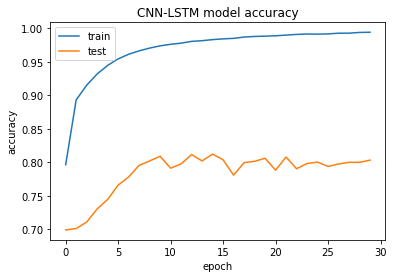

In [31]:
# summarize history for accuracy
plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

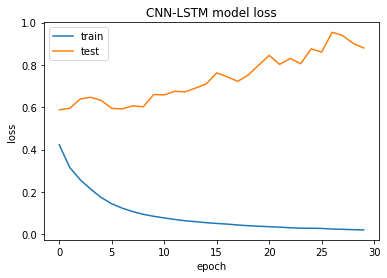

In [32]:
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
cnn_lstm_model.save_weights('./checkpoints/my_checkpoint')

In [34]:
cnn_lstm_model.load_weights('./checkpoints/my_checkpoint')